In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("/home/miri/Documents/bachelorthesis/plots")
from plot_utils import *

2025-03-01 07:58:11.368886: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-01 07:58:11.377790: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-01 07:58:11.380478: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-01 07:58:11.836541: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
data_path = "../../data/adam_wobn"
image_path = "./images"
lr_to_p_fn = lambda js: np.sqrt(0.001/js["optimizer"]["lr"])
lr_to_log_fn = lambda js: np.log(js["optimizer"]["lr"])
wd_to_log_fn = lambda js: np.log(js["optimizer"]["lambda_wd"])
p_to_p_fn = lambda js: js["norm"]["norm_multiply"]
acc_fn = lambda p : max_acc(get_stats(p,"test_stats"))

Max test accuracy of Standard is 81.58% with lr 25000.0
[3.125e-06 6.250e-06 1.250e-05 2.500e-05 5.000e-05 1.000e-04 2.000e-04
 4.000e-04 8.000e-04 1.600e-03 3.200e-03 6.400e-03 1.280e-02 2.560e-02
 5.120e-02]
[0.7336405  0.73884887 0.7515357  0.77537394 0.79620725 0.8098958
 0.8157719  0.808961   0.789797   0.75848025 0.7047276  0.25060096
 0.10743856 0.10984242 0.11017629]


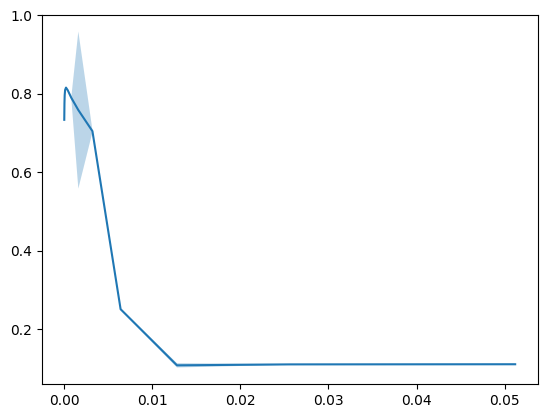

In [9]:
x,y,_ = plot_hyperparam_y(get_subexpspaths(f"{data_path}/noreg"),lambda js : js["optimizer"]["lr"], acc_fn,plt, norm=False,label="noreg")
print("Max test accuracy of Standard is {0}% with lr {1}".format(round(100*y.max(),2),round(0.001/(x[y.argmax()]**2),6)))
print(x)
print(y)


Max test accuracy of norm is 86.08% with p 1.4
Max test accuracy of cnorm is 83.91% with p 1.4
Max test accuracy of cnormu is 85.4% with p 1.2
Max test accuracy of gcstdu is 85.3% with p 1.4
Max test accuracy of wd is 81.51% with lambda 8e-05


(<matplotlib.legend.Legend at 0x7ce530b36840>,
 <matplotlib.legend.Legend at 0x7ce5301f15e0>)

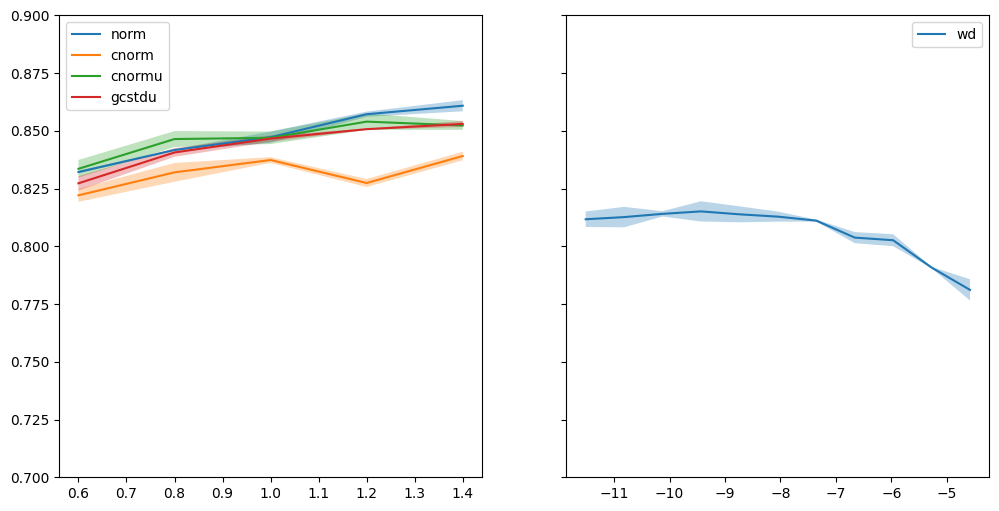

In [5]:
fig,axs = plt.subplots(ncols=2,nrows=1,sharey="row")

for exp in ["norm","cnorm","cnormu","gcstdu"]:
    x,y,_ = plot_hyperparam_y(get_subexpspaths(f"{data_path}/{exp}",skip=lambda s : s.endswith("0")),p_to_p_fn,acc_fn, axs[0], norm=False, label=exp)
    print("Max test accuracy of {0} is {1}% with p {2}".format(exp,round(100*y.max(),2),x[y.argmax()]))

x,y,_ = plot_hyperparam_y(get_subexpspaths(f"{data_path}/wd"),wd_to_log_fn,acc_fn,axs[1], norm=False,label="wd")
print("Max test accuracy of wd is {0}% with lambda {1}".format(round(100*y.max(),2),np.exp(x[y.argmax()])))


fig.set_size_inches(12,6)
axs[0].set_ylim(0.7,0.9)
axs[0].legend(),axs[1].legend()

In [ ]:
exps = ["noreg/0.0002/mg_spacing_0","norm/1.0_1/mg_spacing_0","cnorm/0.8_1/mg_spacing_0","cnormu/0.8_1/mg_spacing_0","gcstdu/1.0_1/mg_spacing_0"]
fig,axs = plt.subplots(ncols=2,nrows=1)
for i,exp in enumerate(exps):
    path = f"{data_path}/{exp}"
    ckpt_paths_grads = get_ckpt_paths(path,"grads")

    @jax.jit
    @partial(jax.vmap,in_axes=(0))
    def get_grad_norm_fn(grads):
        norms = tree_map(lambda w : jnp.linalg.vector_norm(jnp.reshape(w,-1)),grads)
        return norms

    @jax.jit
    @partial(jax.vmap,in_axes=(0))
    @partial(jax.vmap,in_axes=(0))
    def polyfit_fn(norms):

        return jnp.polyfit(jnp.arange(norms.size,dtype=jnp.float32),norms,1)

    x = [e[0] for e in list(ckpt_paths_grads.items())]
    with ThreadPool(processes=12) as pool:
        row_dict = pool.map(lambda e : get_grad_norm_fn(load([e[1]])),list(ckpt_paths_grads.items()))
    
    row_dict = tree_map(lambda *x : jnp.asarray(x) , *[e for e in row_dict if e is not None])
    row_dict = jnp.asarray([val["kernel"] for _,val in row_dict.items()]).T

    polyfit_result = tree_map(polyfit_fn,row_dict)

    mean_m = np.mean(polyfit_result[:,:,0],axis=0)
    std_m = np.std(polyfit_result[:,:,0],axis=0)
    mean_m,std_m = smooth(mean_m,std_m,4)
    axs[0].plot(x,mean_m,label=exp.split("/")[0])
    axs[0].fill_between(x, mean_m-std_m, mean_m+std_m, alpha=0.3)

    mean_b = np.mean(polyfit_result[:,:,1],axis=0)
    std_b = np.std(polyfit_result[:,:,1],axis=0)
    mean_b,std_b = smooth(mean_b,std_b,4)
    axs[1].plot(x,mean_b,label=exp.split("/")[0])
    axs[1].fill_between(x, mean_b-std_b, mean_b+std_b, alpha=0.3)


lines, labels = axs[1].get_legend_handles_labels()
fig.legend(lines, labels, loc='lower center', ncol=len(labels), bbox_to_anchor=(0.5,-0.075), bbox_transform=fig.transFigure)
fig.tight_layout()
fig.set_size_inches(9,4)
